# TP 1 : Classification de cellules tumorales

L'objectif de ce TP est de mettre en application les méthodes de classification vues en cours (Naive Bayes, SVM, LDA, QDA) et de les comparer sur un problème de classification de cellules tumorales. 

## Description des données

Le jeu de données "Breast cancer Wisconsin (Diagnostic) Data Set" (data.csv) contient les informations de 31 features quantitatives sur 569 échantillons provenant de cellules tumorales; la dernière information est un label binaire indiquant si la tumeur est bénigne ("B") ou maligne ("M"). Une description des données est disponibles sur le site UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29). L'objectif est de construire un classifieur permettant de prédire la malignité de la cellule (présence d'un cancer) à partir des 31 features quantitatives. Le jeu de données comporte les colonnes (features) suivantes :


*Identifiant et label*
- id : identifiant unique (integer)
- diagnosis : (M = maligne, B = benigne)

*Mesures quantitatives calculées à partir d'une image médicale de cellules tumorales*
- radius : distance moyenne du noyau cellulaire à la membrane 
- texture : moyenne des valeurs de la nuance de gris dans l'image originale
- perimeter : périmètre moyen des cellules dans l'image
- area : surface moyenne des cellules dans l'image
- smoothness : moyenne de la variation locale dans la taille du rayon (radius)
- compactness : perimeter^2 / area - 1.0
- concavity : sévérité des parties concaves du contour
- concave points : nombre de parties concaves du contour
- symmetry
- fractal dimension : "coastline approximation" - 1

Avec chacune de ces 10 mesures (faites trois fois pour chaque image), on construit 3 features : la moyenne (mean), de l'écart type (se) et la plus grande valeur (worst). Au final, on a pour chaque cellule son ID, le diagnostic, et 30 features quantitatives construites à partir des 10 mesures.


## Importation des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import pandas as pd
import seaborn as sns

## 1 - Exploration rapide des données

#### 1) Chargez les données, affichez leur taille, un extrait des données et un résumé statistique

 On charge les données avec `read_csv` de la librairie `pandas` , on différencie bien la séparation de la décimal, et on indique qu'il y a 32 colonnes.

In [2]:
df = pd.read_csv(
    "data.csv",
    sep=',',
    decimal='.',
    usecols=range(32)
)

On affiche la dimension du jeu de données qu'on a:

Nous avons 569 individus et 32 features, dont 30 features quantitatives, `id` pour l'id du patient et la target `diagnosis`

In [3]:
print("Taille du tableau de données : ",df.shape)

Taille du tableau de données :  (569, 32)


On affiche un extrait des données, pour les 5 premiers individus, afin de voir à quoi ressemble notre jeu de données.

In [4]:
df.head(n=5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Enfin, on affiche un résumé statistique pour voir la moyenne de chaque feature, l'écart type, le minimum ect... (évidemment ce résumé statistique n'a de sens que pour les 30 features quantitatives)

In [5]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


#### 2) Quel est le type de chaque colonne ? Le jeu de données contient-il des données manquantes ? 

On affiche les types de chaque colonnes de la façon suivante : 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Nous avons donc les 30 features quantitatives qui sont des `float` , `id` qui est un entier et `diagnosis` qui est un object ( que nous allons transformer en entier par la suite )

On regarde s'il y a des données manquantes en faisant la somme du nombre de données manquantes sur chaque colonne du tableau

In [7]:
df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

On remarque que le jeu de données n'a pas de données manquantes, ce qui nous arrange car nous n'avons pas besoins de retravailler le jeu de données

## 2 - SVM

#### On va à présent entraîner un SVM pour construire un classifieur de cellules tumorales.

#### 1) Séparez le jeu de données en un ensemble d'entrainement ("training set") et un ensemble de test ("test set")

Nous allons d'abord modifier notre target `y` pour la transformer en entier pour pouvoir appliquer nos différents algorithmes d'entraînement

Transformons donc la colonne `diagnosis` de la façon suivante  :

Si l'individu a une cellule cancéreuse (Maligne), on lui affecte la valeur 1. Si l'individu a une cellule bénigne (Benigne), on lui affecte la valeur -1


In [8]:
y=df.pop("diagnosis")
y[y=='M']=1
y[y=='B']=-1
y = y.astype('int')
y.head(n=6)

0    1
1    1
2    1
3    1
4    1
5    1
Name: diagnosis, dtype: int32

Nos features seront elles stockées dans la variable `X` (on enlèvera la variable `id` qui n'est pas utile pour nos prédictions)

In [9]:
df.pop("id")
X=df
X.head(n=5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Nous allons creer notre training set et notre test set avec la fonction `train_test_split` de la librairie `sklearn.model_selection` , de façon à ce que la taille du test set soit de 25% et celle de notre training set de 75% . De plus, nous allons faire en sorte qu'il y ait la même proportion d'individus atteint de cellule cancéreuse dans les deux sets, et que les sets soient bien crées de façon aléatoire depuis le set total (afin que les individus ne soient pas pris consécutivement, afin d'être sûr d'avoir un certain aléas dans nos sets)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25,
                                                    shuffle=True, random_state=17)

On effectue une petite vérification afin de vérifier que notre répartition dans le training set et le test set a bien été fait 

In [11]:
print("La proportion d'individus atteint de cellules cancéreuses dans le training set :" , np.sum(y_train==1) / y_train.size)
print("La proportion d'individus atteint de cellules cancéreuses dans le test set :" , np.sum(y_test==1)/ y_test.size)

La proportion d'individus atteint de cellules cancéreuses dans le training set : 0.3732394366197183
La proportion d'individus atteint de cellules cancéreuses dans le test set : 0.3706293706293706


#### 2) Entraînez un SVM linéaire avec paramètre C (goodness-of-fit strength) fixé à 1.

In [12]:
from sklearn import svm

In [13]:
C = 1.0  # hyperparamètre fixé à 1
SVM_linear = svm.SVC(kernel='linear', C=C,class_weight="balanced")   #choix de l'algorithme (noyau linéaire)
SVM_linear_model = SVM_linear.fit(X_train, y_train)  # notre entraînement sur le training set
pred_train_svm_linear = SVM_linear_model.predict(X_train)   #Nos prédiction sur le train
pred_test_svm_linear = SVM_linear_model.predict(X_test) #Nos prédictions sur le test

#### 3) Proposez un score d'évaluation pour la classification, et appliquez le au classifieur du SVM linéaire

Nous allons utiliser deux scores d'évaluation dans pour nos classifieurs
- accuracy
- AUC

Nous créons donc nos métriques 

In [14]:
from sklearn import metrics
methods = []
scores_train_accu = []
scores_train_auc = []
scores_test_accu = []
scores_test_auc = []

Puis nous allons calculer l'accuracy de notre algorithme sur le training set puis le test set

In [15]:
accuracy_train = metrics.accuracy_score(y_train, pred_train_svm_linear)  #accuracy sur train 
accuracy_test = metrics.accuracy_score(y_test, pred_test_svm_linear)   #accuracy sur test
method = 'SVM_linear_model_unbalanced'
methods.append(method)
scores_train_accu.append(accuracy_train)
scores_test_accu.append(accuracy_test)
print("Accuracy SVM linéaire on train = ","%.3f" %accuracy_train)
print("Accuracy SVM linéaire on test = ","%.3f" %accuracy_test )



Accuracy SVM linéaire on train =  0.969
Accuracy SVM linéaire on test =  0.951


Et ici nous calculons l'AUC ( c'est à dire l'aire sous la courbe ROC) sur le training set et le test set

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred_train_svm_linear)
auc_train = metrics.auc(fpr, tpr)   #AUC sur train
scores_train_auc.append(auc_train)
print("AUC on train SVM linear = ","%.3f" % auc_train)

AUC on train SVM linear =  0.969


In [17]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_svm_linear)
auc_test = metrics.auc(fpr, tpr)  #AUC sur test
scores_test_auc.append(auc_test)
print("AUC on test SVM linear = ","%.3f" % auc_test)

AUC on test SVM linear =  0.942


#### 4) Reproduisez les deux questions précédentes avec des SVM à noyaux en utilisant les noyaux RBF et sigmoid

### Avec RBF

On réproduit en fait la même chose que pour le noyau linéaire, avec les calculs d'accuracy et d'AUC sur le training set et le test set

In [18]:
C = 1.0  #  hyperparamètre fixé à 1
SVM_rbf = svm.SVC(kernel='rbf', C=C,class_weight="balanced") #choix de l'algorithme
SVM_rbf_model = SVM_rbf.fit(X_train, y_train) # notre entrainement sur le train
pred_train_svm_rbf = SVM_rbf_model.predict(X_train) # Nos prédictions sur le train
pred_test_svm_rbf= SVM_rbf_model.predict(X_test)  # Nos prédictions sur le test

accuracy_train = metrics.accuracy_score(y_train, pred_train_svm_rbf)  
accuracy_test = metrics.accuracy_score(y_test, pred_test_svm_rbf)
method = 'SVM_rbf_model_unbalanced'
methods.append(method)
scores_train_accu.append(accuracy_train)
scores_test_accu.append(accuracy_test)
print("Accuracy SVM rbf on train = ","%.3f" %accuracy_train)
print("Accuracy SVM rbf on test = ","%.3f" %accuracy_test )

Accuracy SVM rbf on train =  0.930
Accuracy SVM rbf on test =  0.881


In [19]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred_train_svm_rbf)
auc_train = metrics.auc(fpr, tpr)
scores_train_auc.append(auc_train)
print("AUC on train SVM rbf = ","%.3f" % auc_train)

AUC on train SVM rbf =  0.916


In [20]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_svm_rbf)
auc_test = metrics.auc(fpr, tpr)
scores_test_auc.append(auc_test)
print("AUC on test SVM rbf = ","%.3f" % auc_test)

AUC on test SVM rbf =  0.863


### Avec sigmoid 

Là encore, on reproduit la même chose (les scores sont extremêment mauvais donc il doit y avoir un problème avec le noyau sigmoide sur ce type de données)

In [21]:
C = 1.0  # hyperparamètre fixé à 1 
SVM_sigmoid = svm.SVC(kernel='sigmoid', C=C,class_weight="balanced") #choix de l'algorithme
SVM_sigmoid_model = SVM_sigmoid.fit(X_train, y_train) 
pred_train_svm_sigmoid = SVM_sigmoid_model.predict(X_train) 
pred_test_svm_sigmoid= SVM_sigmoid_model.predict(X_test)  

accuracy_train = metrics.accuracy_score(y_train, pred_train_svm_sigmoid)  
accuracy_test = metrics.accuracy_score(y_test, pred_test_svm_sigmoid)
method = 'SVM_sigmoid_model_unbalanced'
methods.append(method)
scores_train_accu.append(accuracy_train)
scores_test_accu.append(accuracy_test)
print("Accuracy SVM sigmoid on train = ","%.3f" %accuracy_train)
print("Accuracy SVM sigmoid on test = ","%.3f" %accuracy_test )

Accuracy SVM sigmoid on train =  0.291
Accuracy SVM sigmoid on test =  0.294


In [22]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred_train_svm_sigmoid)
auc_train = metrics.auc(fpr, tpr)
scores_train_auc.append(auc_train)
print("AUC on train SVM sigmoid = ","%.3f" % auc_train)

AUC on train SVM sigmoid =  0.292


In [23]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test_svm_sigmoid)
auc_test = metrics.auc(fpr, tpr)
scores_test_auc.append(auc_test)
print("AUC on test SVM sigmoid = ","%.3f" % auc_test)

AUC on test SVM sigmoid =  0.315


####  5) Que pouvez-vous conclure des scores obtenus pour ces trois classifieurs ?

Pour le premier classifieur (linéaire), l'accuracy et l'AUC sont très bons , elles sont de l'ordre de 0.92

Pour le second classifieur (RBF), l'accuracy et l'AUC sont aussi très bons, de l'ordre de 0.90

Cependant, pour le dernier classifieur (sigmoid), les scores sont très mauvais, on est de l'ordre de 0.3, il y a sans doute un problème pour ce type de données (sachant que si on crée un classifieur qui renvoie tout le temps -1, son accuracy serait déjà de l'ordre de 0.627 car il y a 357 sur 569 indivius qui n'ont pas une tumeur cancéreuse)

#### 6) À l'aide d'une validation croisée, sélectionnez le meilleur paramètre C pour chacun des trois classifieurs précédents, et représentez les valeurs du score pour une grille de C sur une figure

Nous allons ici utiliser la fonction `GridSearchCV` de la librairie `sklearn.model_selection` pour nous permettre de trouver les hyperparamètres tels que le score soit le plus élevé possible.

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

### Paramètre C dans le cas linéaire

In [25]:
parameters = {'kernel':np.array(['linear']), 'C':[10,100]}  # Notre grille de valeur de C
svc = svm.SVC()                    # Notre classifieur
svc_grids = GridSearchCV(svc, parameters)   #On indique à GridSearchCV notre classifieur et nos paramètres
svc_grids.fit(X_train, y_train)    #On entraine sur le train
print(svc_grids.best_params_)    #On renvoie les hyperparamètres pour lesquels le score est le plus élevé
svc_grids.best_score_     #On renvoie le score

{'C': 10, 'kernel': 'linear'}


0.9553761969904242

Après plusieurs essais avec le code au dessus, on trouve que notre notre hyper-paramètre C est d'une valeur de 10 dans le cas linéaire

On va représenter les valeurs du score sur une figure pour une grille de C 

dans le cas linéaire on se contentera de quelques valeurs de C car le temps de calcul est plutôt long (du moins sur mon ordinateur)

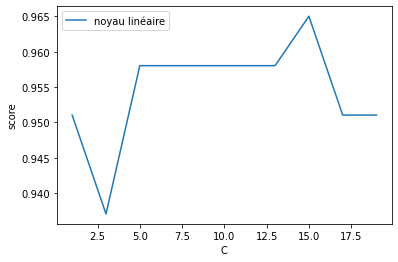

In [26]:
test_score=[]
for i in range(1,20,2):    #notre grille de valeur de C
    SVM_linear = svm.SVC(kernel='linear', C=i,class_weight="balanced")   #choix de l'algorithme (noyau linéaire)
    SVM_linear.fit(X_train,y_train)
    score=SVM_linear.score(X_test,y_test)
    test_score.append(score)
test_score
plt.plot(range(1,20,2) , test_score,label="noyau linéaire")

plt.ylabel("score")
plt.xlabel("C")
plt.legend()

Avec notre graphique on peut même determiner que le meilleur hyperparamètre C serait autour de 14

## Paramètre C dans le cas RBF

On effectue la même démarche dans le cadre d'une RBF

In [27]:
parameters = {'kernel':np.array(['rbf']), 'C':np.arange(3700,3800,1)}    #Grille de valeur de C
svc = svm.SVC()
svc_grids = GridSearchCV(svc, parameters)
svc_grids.fit(X_train, y_train)
print(svc_grids.best_params_)     #On renvoie les hyperparamètres pour lesquels le score est le plus élevé
svc_grids.best_score_  #On renvoie le score

{'C': 3709, 'kernel': 'rbf'}


0.962407660738714

Après plusieurs essais, on trouve que notre hyperparamètre C est d'une valeur de 3709 dans le cas d'une RBF

De même, on va représenter les valeurs du score sur une figure pour une grille de C 

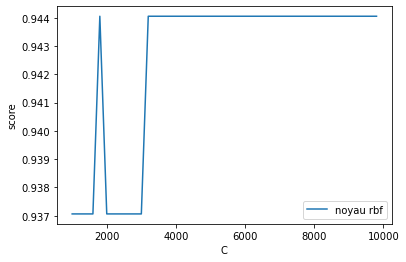

In [28]:
test_score=[]
for i in range(1000,10000,200):    #grille de valeur de C
    SVM_RBF = svm.SVC(kernel='rbf', C=i,class_weight="balanced")   #choix de l'algorithme (noyau RBF)
    SVM_RBF.fit(X_train,y_train)
    score=SVM_RBF.score(X_test,y_test)
    test_score.append(score)
test_score
plt.plot(range(1000,10000,200), test_score,label="noyau rbf")

plt.ylabel("score")
plt.xlabel("C")
plt.legend()

Ici, avec ce graphique, on peut confirmer notre 1ère approximation de l'hyperparamètre, on voit bien qu'il peut se trouver autour de 4000

## Paramètre C dans le cas sigmoid

In [29]:
parameters = {'kernel':np.array(['sigmoid']), 'C':np.arange(0.2,0.6,0.05)}
svc = svm.SVC()
svc_grids = GridSearchCV(svc, parameters)
svc_grids.fit(X_train, y_train)
#GridSearchCV(estimator=svc(),param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})
print(svc_grids.best_params_)
svc_grids.best_score_

{'C': 0.44999999999999996, 'kernel': 'sigmoid'}


0.6385225718194254

Après plusieurs essais, on trouve que notre hyperparamètre C est d'une valeur de 0.45 dans le cas d'une sigmoid

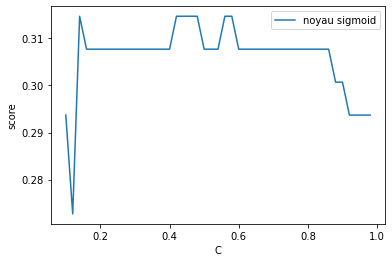

In [30]:
test_score=[]
for i in np.arange(0.1,1,0.02):     #grille de valeur de C
    SVM_sigmoid = svm.SVC(kernel='sigmoid', C=i,class_weight="balanced")   #choix de l'algorithme (noyau sigmoid)
    SVM_sigmoid.fit(X_train,y_train)
    score=SVM_sigmoid.score(X_test,y_test)
    test_score.append(score)
test_score
plt.plot(np.arange(0.1,1,0.02), test_score,label="noyau sigmoid")

plt.ylabel("score")
plt.xlabel("C")
plt.legend()

Avec notre graphique on peut determiner que le meilleur hyperparamètre serait autour de 0.5, tout comme on l'avait presque prédit avec la fonction `GridSearchCV`

#### 7) Conclure

Pour conclure, on constate qu'une SVM à noyau linéaire est un très bon model si nous prenons pour métrique l'accuracy et l'AUC. De plus, la recherche du meilleur hyperparamètre permet encore mieux d'augmenter l'efficacité du modèle sur ces métriques.
La SVM à noyau RBF est elle aussi très convaincante en terme de résultat sur ces métriques là.
Cependant, la SVM à noyau sigmoid est très mauvaise sur ces métriques, cela est sûrement dû aux types de données que nous avons.

## 3 - Naive Bayes, LDA, QDA

Nous allons à présent utiliser d'autres méthodes de classification vues précédemment en cours : le classifieur Naive bayes, l'Analyse Discriminante Linéaire (LDA) et l'Analyse Discriminante Quadratique (QDA).



In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#### 1) Rappelez en quelques phrases le principe du classifieur Naive Bayes.


Le classifieur Naive Bayes repose sur le théorème de Bayes et l'indépendance des features, il utilise le principe de maximum de vraissemblance.

De fait, si on note $\mathbb{P}_M$ la probabilité d'avoir une tumeur cancéreuse et $\mathbb{P}_B$ la probabilité d'avoir une tumeur bénigne pour un individu donné avec ses 30 features $X_i$, alors on à 
$\mathbb{P}_M = \prod_1^{30} \mathbb{P}(X_i | \mbox{ Maligne} )\times (\mbox{proportion de Maligne})$
et $\mathbb{P}_B = \prod_1^{30} \mathbb{P}(X_i | \mbox{ Benigne} )\times (\mbox{proportion de Benigne})$

On prend ensuite la plus grande proba entre $\mathbb{P}_M$ et  $\mathbb{P}_B$ pour determiner à quelle classe appartient cet individu.

#### 2) Entraînez le classifieur Naive Bayes sur le jeu de données et calculer le score associé

In [32]:
Bayes=GaussianNB()        #On a notre classifieur 
Bayes.fit(X_train,y_train)     #On l'entraine sur les données d'entraînement.
print("Score sur le train avec naive Bayes :", Bayes.score(X_train,y_train))   #On affiche le score sur le train
print("Score sur le test avec naive Bayes :", Bayes.score(X_test,y_test))   #On affiche le score sur le test

Score sur le train avec naive Bayes : 0.9436619718309859
Score sur le test avec naive Bayes : 0.9370629370629371


#### 3) Rappelez en quelques phrases le principe de LDA et QDA. Quelle est la différence fondamentale entre ces deux méthodes ? (Reprendre le Problème 2 du TD 1 si besoin)

La LDA et la QDA, comme pour la classification Naive Bayésienne, utilise le principe de maximum de vraissemblance pour prédire la classe d'un individu.

La LDA suppose des données normalement distribuées et un vecteur moyen spécifique à la classe, de plus, la LDA suppose une matrice de covariance commune à toutes les classes, ce qui n'est pas le cas de la QDA, qui elle suppose que chaque classe a sa propre matrice de covariance.

#### 4) Entraînez les classifieurs LDA et QDA sur les données et calculer leur score

In [33]:
LDA=LinearDiscriminantAnalysis()
LDA.fit(X_train,y_train)
print("Score sur le train pour la LDA:", LDA.score(X_train,y_train))
print("Score sur le test pour la LDA:", LDA.score(X_test,y_test))

Score sur le train pour la LDA: 0.9647887323943662
Score sur le test pour la LDA: 0.965034965034965


In [34]:
QDA=QuadraticDiscriminantAnalysis()
QDA.fit(X_train,y_train)
print("Score sur le train pour la QDA:", QDA.score(X_train,y_train))
print("Score sur le test pour la QDA:", QDA.score(X_test,y_test))

Score sur le train pour la QDA: 0.971830985915493
Score sur le test pour la QDA: 0.958041958041958


## 4 - kNN

On va maintenant appliquer la méthode des k plus proches voisins (kNN, k nearest neighbors)

In [35]:
from sklearn.neighbors import KNeighborsClassifier

#### 1) Appliquer la méthode kNN pour la classification avec k=5 fixé, et calculer l'erreur correspondante.

In [36]:
kneighbors=KNeighborsClassifier(n_neighbors=5)    # On fixe k = 5
kneighbors.fit(X_train,y_train)   #On entraine
print("Score sur le train :", kneighbors.score(X_train,y_train))
print("Score sur le test :", kneighbors.score(X_test,y_test))

Score sur le train : 0.9413145539906104
Score sur le test : 0.9300699300699301


L'erreur correspondante est donc `1-kneighbors.score(X_test,y_test)` 

C'est à dire 0.077

#### 2) Appliquer la même méthode pour une grille de k entre 1 et 20, représenter le score sur une figure et conclure sur l'importance du choix de k.

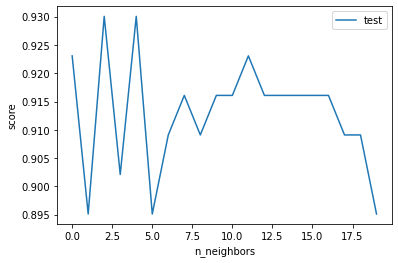

In [37]:
#On va d'abord le faire " à la main" avec une boucle for


test_score=[]   #liste des scores
for i in range(1,21):    #Notre grille du nombre de plus proche voisins
    kneighbor=KNeighborsClassifier(n_neighbors=i)
    kneighbor.fit(X_train,y_train)
    score=kneighbor.score(X_test,y_test)    #On prend le score
    test_score.append(score)
test_score
plt.plot(test_score,label="test")

plt.ylabel("score")
plt.xlabel("n_neighbors")
plt.legend()

On remarque que les meilleurs résultats se trouvent pour k entre 10 et 12 

Nous allons maintenant le faire avec la fonction `validation_curve` de la librairie `sklearn.model_selection` qui permet directement de faire ce qu'on vient de faire, mais de façon plus agréable.

In [38]:
from sklearn.model_selection import validation_curve

C:\Users\skinz\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass param_name=n_neighbors, param_range=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


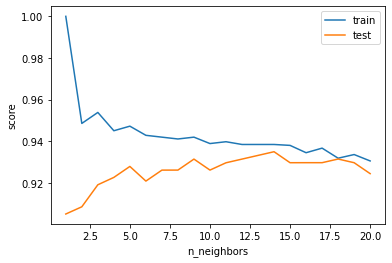

In [39]:
k=np.arange(1,21)   #grille du nombre de plus proche voisins
train_score, test_score = validation_curve(kneighbors, X, y , "n_neighbors", k)

plt.plot(k,train_score.mean(axis=1),label="train")   #On fait un mean car il y a une cross-validation
plt.plot(k,test_score.mean(axis=1),label="test")  #De même

plt.ylabel("score")
plt.xlabel("n_neighbors")
plt.legend()

On trouve ici que le nombre de voisins optimal est plutôt autour de 14, ceci est sûrement dû à la cross-validation qu'effectue la fonction `validation_curve` par défaut `(cv=5)` , de plus, le vecteur `y_test` n'est pas le même , car ici c'est la fonction `validation_curve` qui en crée un . Cependant on obtient aussi de très bon résultat pour $k\in [\![10,12]\!]$
Effectuons une dernière fois cette démarche avec la fonction `GridSearchCV` permettant de trouver directement le meilleur hyperparamètre

In [40]:
param_grid = { "n_neighbors" : np.arange(1,21)}
grid=GridSearchCV(KNeighborsClassifier(),param_grid,cv=5 )
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])})

In [41]:
print("Le meilleur paramètre est le suivant :", grid.best_params_)
model=grid.best_estimator_
print("Le score sur le test : ",model.score(X_test,y_test))

Le meilleur paramètre est le suivant : {'n_neighbors': 17}
Le score sur le test :  0.916083916083916


On trouve ici k=17. Cette différence de résultat est sûrement dû à la cross-validation et que cette fois, il n'y a aucun apprentissage sur le test , car évidemment, si on cherche le meilleur nombre de voisin en se basant sur le score sur le test, en quelque sorte on s'entraine sur le test, on est donc en overfitting.

## 5- Autres méthodes de classification

#### Essayer d'autres méthodes de classification

Nous allons en premier lieu utiliser une méthode de classification par arbre de décision

In [42]:
from sklearn.tree import DecisionTreeClassifier

In [43]:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2)   #Arbre de profondeur 2
decision_tree.fit(X_train,y_train)
decision_tree.score(X_test,y_test)

0.951048951048951

On peut se demander là aussi quelle serait la meilleur profondeur d'arbre pour améliorer le score sur le test

Comme précédemment on peut le faire avec la fonction `validation_curve` en faisant varier k de 1 à 20 

C:\Users\skinz\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass param_name=max_depth, param_range=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


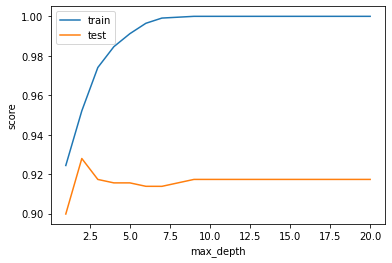

In [44]:
k=np.arange(1,21)    #grille de profondeur d'arbre
train_score, test_score = validation_curve(decision_tree, X, y , "max_depth", k)

plt.plot(k,train_score.mean(axis=1),label="train")
plt.plot(k,test_score.mean(axis=1),label="test")

plt.ylabel("score")
plt.xlabel("max_depth")
plt.legend()

On trouve qu'a partir de 5 de profondeur, notre score de test atteint presque son maximum, qu'il ne sert sans doute à rien de montrer plus haut.

En le faisant avec la fonction `GridSearchCV`, on obtient donc la meilleur profondeur d'arbre, une différence avec le graphique qui là aussi peut s'expliquer par les même arguments que précédemment pour les K Nearest Neighbors.

In [45]:
param_grid = { "max_depth" : np.arange(1,21)}
grid=GridSearchCV(DecisionTreeClassifier(),param_grid,cv=5 )
grid.fit(X_train,y_train)


print("Le meilleur paramètre est le suivant :", grid.best_params_)
model=grid.best_estimator_
print("Le score sur le test : ",model.score(X_test,y_test))

Le meilleur paramètre est le suivant : {'max_depth': 3}
Le score sur le test :  0.916083916083916


Puis nous pouvons aussi tester une méthode de classification par Adaboost.

Nous allons prendre ici 100 weak learners pour tester notre méthode, et le score est très élevée.

In [46]:
from sklearn.ensemble import AdaBoostClassifier

In [47]:
adaboost=AdaBoostClassifier(n_estimators=100)   #100 weak learners
adaboost.fit(X_train,y_train)
adaboost.score(X_test,y_test)

0.958041958041958

## 6 - Comparaison des méthodes de classification

#### 1) Conclure sur les différentes méthodes de classification pour le jeu de données considéré, à l'aide des questions précédentes 

On remarque finalement que toutes les méthodes de classification sont très bonnes par rapport aux métriques accuracy et AUC apart la svm à noyau sigmoid qui est vraiment très mauvaise .
Certaines comme la LDA et la SVM à noyau linéaire avec un bon hyperparamètre bien choisi ont une accuracy pouvant atteindre 0.96, ce qui est très élevé.

#### 2) La comparaison des méthodes dépend fortement du score choisi. En pratique, un faux négatif (cancer réel non détecté) est plus grave qu'un faux positif (absence de cancer détectée comme cancer). Comment peut-on adapter le score (et la méthode d'apprentissage) pour prendre cela en compte ?

On peut adapter le score en prenant cette fois-ci le recall au lieu de l'accuracy.
En effet, plus le recall sera élevé, et plus le nombre de faux négative sera faible, c'est à dire que pour les individus qui ont une cellule cancéreuse, la probabilité qu'on l'a détecte est plus élevé.

#### 3) Proposez un score alternatif, et comparez de nouveau les méthodes précédentes. Conclure.

On propose donc de prendre le recall au lieu de prendre l'accuracy comme métrique.
Il suffit de rajouter une ligne de code (en précisant la métrique choisit)
En reprenant l'ordre des questions, on a donc :

In [48]:

print("Pour la SVM linéaire le recall est :" , metrics.recall_score(y_test,SVM_linear_model.predict(X_test)))
print("Pour la SVM RBF le recall est :" , metrics.recall_score(y_test,SVM_rbf_model.predict(X_test)))
print("Pour la SVM sigmoid le recall est :" , metrics.recall_score(y_test,SVM_sigmoid_model.predict(X_test)))

print("Pour Bayes Naive le recall est :" , metrics.recall_score(y_test,Bayes.predict(X_test)))
print("Pour la LDA le recall est :" , metrics.recall_score(y_test,LDA.predict(X_test)))
print("Pour la QDA le recall est :" , metrics.recall_score(y_test,QDA.predict(X_test)))
print("Pour KNN le recall est :" , metrics.recall_score(y_test,kneighbors.predict(X_test)))
print("Pour l'arbre de décision le recall est :" , metrics.recall_score(y_test,decision_tree.predict(X_test)))
print("Pour Adaboost le recall est :" , metrics.recall_score(y_test,adaboost.predict(X_test)))

Pour la SVM linéaire le recall est : 0.9056603773584906
Pour la SVM RBF le recall est : 0.7924528301886793
Pour la SVM sigmoid le recall est : 0.39622641509433965
Pour Bayes Naive le recall est : 0.8679245283018868
Pour la LDA le recall est : 0.9056603773584906
Pour la QDA le recall est : 0.9245283018867925
Pour KNN le recall est : 0.8679245283018868
Pour l'arbre de décision le recall est : 0.9245283018867925
Pour Adaboost le recall est : 0.8867924528301887


Contrairement à l'accuracy, on constate avec le recall des disparités entre les différentes méthodes.
On distingue deux méthodes qui ont des bons recall : La QDA et l'arbre de décision ( avec seulement 2 de profondeur d'arbre).


On conclut cependant qu'en cherchant les hyperparamètres là aussi avec `GridSearchCV` on peut espérer trouver encore de meilleurs résultats pour cette métrique ci.

Finalement, si on devait ressortir avec une seule methode, je pense que la QDA serait le plus adapté pour ce type de données, au vu des performances sur le recall et l'accuracy.